**Dataset folder structure:**

The root folder '/content/drive/MyDrive/FARIL-SORG/cartilaginous-tumors-dataset' should contain two subfolders, "train" and "val", where the "train" folder contains two subfolders, "chondrosarcoma" and "enchondroma" and the "val" folder also contains two subfolders, "chondrosarcoma" and "enchondroma".

Each patient has a folder corresponding to their ID that contains their two images, should be placed in the appropriate subfolder. It's good practice to randomly split the patient data so that 80% of the patients are in the "train" folder and the remaining 20% are in the "val" folder.

With this folder structure, you can use the flow_from_directory method of the ImageDataGenerator class to automatically generate batches of images and labels for training and validation. This method will look into the subfolders and automatically label the images according to the folder they are in.

This lets you load the data by passing the path of the train and val folders to the flow_from_directory method.

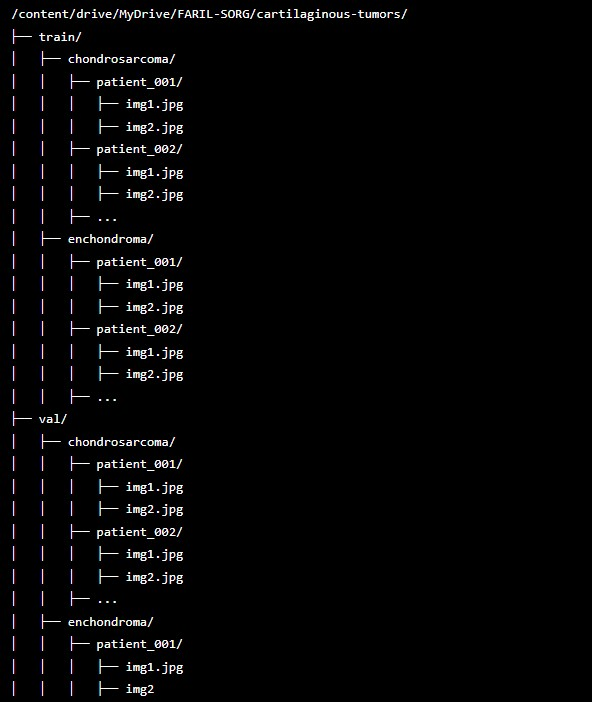

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
#from keras.applications.resnet import ConvNeXtBase
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from tensorflow.python.util.tf_export import keras_export

## STOP. You have to run the long python scripts at the very bottom of the notebook at this point.

In [4]:
@keras_export(
    "keras.applications.convnext.ConvNeXtSmall",
    "keras.applications.ConvNeXtSmall",
)
def ConvNeXtSmall(
    model_name="convnext_small",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["small"]["depths"],
        projection_dims=MODEL_CONFIGS["small"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["small"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


In [5]:
seed = 42
num_epochs = 50
batch_size = 16

# path to dataset on google drive
path_to_dataset = '/content/drive/MyDrive/FARIL-SORG/cartilaginous-tumors-dataset'

In [10]:
# create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    rotation_range=40,  # randomly rotate images by up to 40 degrees
    #rotation_range=10,  # randomly rotate images by up to 10 degrees
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2,  # randomly shift images vertically
    shear_range=0.2,  # randomly apply shearing transformations
    zoom_range=0.2,  # randomly zoom in and out
    #shear_range=0.1,  # randomly apply shearing transformations
    #zoom_range=0.1,  # randomly zoom in and out
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest')  # fill in newly created pixels

# create a generator for training data
train_generator = datagen.flow_from_directory(
    os.path.join(path_to_dataset, 'train'),  # directory containing training data
    target_size=(224, 224),  # resize images to 224x224 pixels
    batch_size=16, # modify the batch size
    shuffle=True,
    class_mode='categorical',
    seed=seed
)

# create a generator for validation data
val_generator = datagen.flow_from_directory(
    os.path.join(path_to_dataset, 'val'),  # directory containing validation data
    target_size=(224, 224),  # resize images to 224x224 pixels
    batch_size=16, # modify the batch size
    shuffle=True,
    class_mode='categorical',
    seed=seed
)

# specify the number of steps to take from the generator before moving to the next epoch
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

# Load ConvNeXtSmall model
base_model = ConvNeXtSmall(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# define two input layers for the two images
input_img1 = Input(shape=(224, 224, 3))
input_img2 = Input(shape=(224, 224, 3))

# Load ConvNeXtSmall model
base_model = ConvNeXtSmall(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output of ConvNeXtSmall model for image 1
x1 = base_model(input_img1)

# Get output of ConvNeXtTiny model for image 2
x2 = base_model(input_img2)

# Concatenate the output
concatenated_output = concatenate([x1, x2])

# specify the weight decay rate
weight_decay = 1e-3

# add additional layers, and EXPERIMENT WITH DIFFERENT HYPERPARAMETERS
# Units: 128, 256, 512, 1024
# Dropout: min_value=0.0, max_value=0.5, step=0.1
# Learning rate: min_value=1e-4, max_value=1e-2, step=1e-4
# Weight decay: 0.001, 0.0001, 0.00001, 0.000001 (1e-3 to 1e-6)

# add additional layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=weight_decay)

# compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

Found 980 images belonging to 2 classes.
Found 236 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=int(980/batch_size),
                              epochs=50,
                              validation_data=val_generator,
                              validation_steps=int(244/batch_size),
                              callbacks=[early_stop, model_checkpoint])

<ipython-input-11-34d441bc7861>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.7828 - acc: 0.5353
Epoch 1: val_loss improved from inf to 0.88129, saving model to best_model.h5
61/61 [==============================] - 69s 828ms/step - loss: 1.7828 - acc: 0.5353 - val_loss: 0.8813 - val_acc: 0.5551
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.8521 - acc: 0.5218
Epoch 2: val_loss improved from 0.88129 to 0.83093, saving model to best_model.h5
61/61 [==============================] - 43s 705ms/step - loss: 0.8521 - acc: 0.5218 - val_loss: 0.8309 - val_acc: 0.5424
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.8153 - acc: 0.5164
Epoch 3: val_loss improved from 0.83093 to 0.79999, saving model to best_model.h5
61/61 [==============================] - 44s 718ms/step - loss: 0.8153 - acc: 0.5164 - val_loss: 0.8000 - val_acc: 0.5424
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.7899 - acc: 0.5166
Epoch 4: val_loss improved from 0.79

KeyboardInterrupt: ignored

In [ ]:
#loss: 0.7087 - acc: 0.5654 - val_loss: 0.6964 - val_acc: 0.6737
#changed input from 256 to 128 

In [ ]:
# import Matplotlib
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend

## Now let's apply Keras Tuner to optimize the hyperparameters automatically!

In [ ]:
import kerastuner

In [ ]:
!pip install keras-tuner

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    # define two input layers for the two images
    input_img1 = Input(shape=(224, 224, 3))
    input_img2 = Input(shape=(224, 224, 3))

    # Load VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Get output of VGG16 model for image 1
    x1 = base_model(input_img1)

    # Get output of VGG16 model for image 2
    x2 = base_model(input_img2)

    # Concatenate the output
    concatenated_output = concatenate([x1, x2])

    # add additional layers
    x = concatenated_output
    x = Flatten()(x)
    x = Dense(hp.Int('units', 64, 256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dropout', 0, 0.5))(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input_img1, input_img2], outputs=predictions)
    model.compile(
        optimizer=optimizers.RMSprop(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='/content/drive/MyDrive/FARIL-SORG/cartilaginous-tumors-dataset/tuner',
    project_name='multiview_classification')

tuner.search(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


To create a web browser API for your trained model, you will need to use a web framework such as Flask or Django to create the API endpoint that will handle the incoming requests from the web browser. You will also need to use a web server such as Apache or Nginx to host the API.

##**You might be able to use Flask to create a web browser API for your model**

In [7]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_tiny_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth",
    "convnext_small_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

@register_model
def convnext_tiny(pretrained=False,in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_22k'] if in_22k else model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_small(pretrained=False,in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_small_22k'] if in_22k else model_urls['convnext_small_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_base(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    if pretrained:
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_large(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    if pretrained:
        url = model_urls['convnext_large_22k'] if in_22k else model_urls['convnext_large_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_xlarge(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    if pretrained:
        assert in_22k, "only ImageNet-22K pre-trained ConvNeXt-XL is available; please set in_22k=True"
        url = model_urls['convnext_xlarge_22k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

In [9]:
"""ConvNeXt models for Keras.
References:
- [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)
  (CVPR 2022)
"""

import numpy as np
import tensorflow.compat.v2 as tf

from keras import backend
from keras import layers
from keras import utils
from keras.applications import imagenet_utils
from keras.engine import sequential
from keras.engine import training as training_lib

# isort: off
from tensorflow.python.util.tf_export import keras_export

BASE_WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/convnext/"
)

WEIGHTS_HASHES = {
    "convnext_tiny": (
        "8ae6e78ce2933352b1ef4008e6dd2f17bc40771563877d156bc6426c7cf503ff",
        "d547c096cabd03329d7be5562c5e14798aa39ed24b474157cef5e85ab9e49ef1",
    ),
    "convnext_small": (
        "ce1277d8f1ee5a0ef0e171469089c18f5233860ceaf9b168049cb9263fd7483c",
        "6fc8009faa2f00c1c1dfce59feea9b0745eb260a7dd11bee65c8e20843da6eab",
    ),
    "convnext_base": (
        "52cbb006d3dadd03f6e095a8ca1aca47aecdd75acb4bc74bce1f5c695d0086e6",
        "40a20c5548a5e9202f69735ecc06c990e6b7c9d2de39f0361e27baeb24cb7c45",
    ),
    "convnext_large": (
        "070c5ed9ed289581e477741d3b34beffa920db8cf590899d6d2c67fba2a198a6",
        "96f02b6f0753d4f543261bc9d09bed650f24dd6bc02ddde3066135b63d23a1cd",
    ),
    "convnext_xlarge": (
        "c1f5ccab661354fc3a79a10fa99af82f0fbf10ec65cb894a3ae0815f17a889ee",
        "de3f8a54174130e0cecdc71583354753d557fcf1f4487331558e2a16ba0cfe05",
    ),
}


MODEL_CONFIGS = {
    "tiny": {
        "depths": [3, 3, 9, 3],
        "projection_dims": [96, 192, 384, 768],
        "default_size": 224,
    },
    "small": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [96, 192, 384, 768],
        "default_size": 224,
    },
    "base": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [128, 256, 512, 1024],
        "default_size": 224,
    },
    "large": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [192, 384, 768, 1536],
        "default_size": 224,
    },
    "xlarge": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [256, 512, 1024, 2048],
        "default_size": 224,
    },
}

BASE_DOCSTRING = """Instantiates the {name} architecture.
  References:
    - [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)
    (CVPR 2022)
  For image classification use cases, see
  [this page for detailed examples](
  https://keras.io/api/applications/#usage-examples-for-image-classification-models).
  For transfer learning use cases, make sure to read the
  [guide to transfer learning & fine-tuning](
    https://keras.io/guides/transfer_learning/).
  The `base`, `large`, and `xlarge` models were first pre-trained on the
  ImageNet-21k dataset and then fine-tuned on the ImageNet-1k dataset. The
  pre-trained parameters of the models were assembled from the
  [official repository](https://github.com/facebookresearch/ConvNeXt). To get a
  sense of how these parameters were converted to Keras compatible parameters,
  please refer to
  [this repository](https://github.com/sayakpaul/keras-convnext-conversion).
  Note: Each Keras Application expects a specific kind of input preprocessing.
  For ConvNeXt, preprocessing is included in the model using a `Normalization`
  layer.  ConvNeXt models expect their inputs to be float or uint8 tensors of
  pixels with values in the [0-255] range.
  When calling the `summary()` method after instantiating a ConvNeXt model,
  prefer setting the `expand_nested` argument `summary()` to `True` to better
  investigate the instantiated model.
  Args:
    include_top: Whether to include the fully-connected
      layer at the top of the network. Defaults to True.
    weights: One of `None` (random initialization),
      `"imagenet"` (pre-training on ImageNet-1k), or the path to the weights
      file to be loaded. Defaults to `"imagenet"`.
    input_tensor: Optional Keras tensor
      (i.e. output of `layers.Input()`)
      to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
      if `include_top` is False.
      It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
      when `include_top` is `False`. Defaults to None.
      - `None` means that the output of the model will be
        the 4D tensor output of the last convolutional layer.
      - `avg` means that global average pooling
        will be applied to the output of the
        last convolutional layer, and thus
        the output of the model will be a 2D tensor.
      - `max` means that global max pooling will
        be applied.
    classes: Optional number of classes to classify images
      into, only to be specified if `include_top` is True, and
      if no `weights` argument is specified. Defaults to 1000 (number of
      ImageNet classes).
    classifier_activation: A `str` or callable. The activation function to use
      on the "top" layer. Ignored unless `include_top=True`. Set
      `classifier_activation=None` to return the logits of the "top" layer.
      Defaults to `"softmax"`.
      When loading pretrained weights, `classifier_activation` can only
      be `None` or `"softmax"`.
  Returns:
    A `keras.Model` instance.
"""


class StochasticDepth(layers.Layer):
    """Stochastic Depth module.
    It performs batch-wise dropping rather than sample-wise. In libraries like
    `timm`, it's similar to `DropPath` layers that drops residual paths
    sample-wise.
    References:
      - https://github.com/rwightman/pytorch-image-models
    Args:
      drop_path_rate (float): Probability of dropping paths. Should be within
        [0, 1].
    Returns:
      Tensor either with the residual path dropped or kept.
    """

    def __init__(self, drop_path_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_rate = drop_path_rate

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path_rate
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_path_rate": self.drop_path_rate})
        return config


class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config


def ConvNeXtBlock(
    projection_dim, drop_path_rate=0.0, layer_scale_init_value=1e-6, name=None
):
    """ConvNeXt block.
    References:
    - https://arxiv.org/abs/2201.03545
    - https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
    Notes:
      In the original ConvNeXt implementation (linked above), the authors use
      `Dense` layers for pointwise convolutions for increased efficiency.
      Following that, this implementation also uses the same.
    Args:
      projection_dim (int): Number of filters for convolution layers. In the
        ConvNeXt paper, this is referred to as projection dimension.
      drop_path_rate (float): Probability of dropping paths. Should be within
        [0, 1].
      layer_scale_init_value (float): Layer scale value. Should be a small float
        number.
      name: name to path to the keras layer.
    Returns:
      A function representing a ConvNeXtBlock block.
    """
    if name is None:
        name = "prestem" + str(backend.get_uid("prestem"))

    def apply(inputs):
        x = inputs

        x = layers.Conv2D(
            filters=projection_dim,
            kernel_size=7,
            padding="same",
            groups=projection_dim,
            name=name + "_depthwise_conv",
        )(x)
        x = layers.LayerNormalization(epsilon=1e-6, name=name + "_layernorm")(x)
        x = layers.Dense(4 * projection_dim, name=name + "_pointwise_conv_1")(x)
        x = layers.Activation("gelu", name=name + "_gelu")(x)
        x = layers.Dense(projection_dim, name=name + "_pointwise_conv_2")(x)

        if layer_scale_init_value is not None:
            x = LayerScale(
                layer_scale_init_value,
                projection_dim,
                name=name + "_layer_scale",
            )(x)
        if drop_path_rate:
            layer = StochasticDepth(
                drop_path_rate, name=name + "_stochastic_depth"
            )
        else:
            layer = layers.Activation("linear", name=name + "_identity")

        return inputs + layer(x)

    return apply


def PreStem(name=None):
    """Normalizes inputs with ImageNet-1k mean and std.
    Args:
      name (str): Name prefix.
    Returns:
      A presemt function.
    """
    if name is None:
        name = "prestem" + str(backend.get_uid("prestem"))

    def apply(x):
        x = layers.Normalization(
            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
            variance=[
                (0.229 * 255) ** 2,
                (0.224 * 255) ** 2,
                (0.225 * 255) ** 2,
            ],
            name=name + "_prestem_normalization",
        )(x)
        return x

    return apply


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


def ConvNeXt(
    depths,
    projection_dims,
    drop_path_rate=0.0,
    layer_scale_init_value=1e-6,
    default_size=224,
    model_name="convnext",
    include_preprocessing=True,
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates ConvNeXt architecture given specific configuration.
    Args:
      depths: An iterable containing depths for each individual stages.
      projection_dims: An iterable containing output number of channels of
      each individual stages.
      drop_path_rate: Stochastic depth probability. If 0.0, then stochastic
        depth won't be used.
      layer_scale_init_value: Layer scale coefficient. If 0.0, layer scaling
        won't be used.
      default_size: Default input image size.
      model_name: An optional name for the model.
      include_preprocessing: boolean denoting whther to include preprocessing in
        the model. When `weights="imagenet"` this should be always set to True.
        But for other models (e.g., randomly initialized) users should set it
        to False and apply preprocessing to data accordingly.
      include_top: Boolean denoting whether to include classification head to
        the model.
      weights: one of `None` (random initialization), `"imagenet"` (pre-training
        on ImageNet-1k), or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor (i.e. output of `layers.Input()`) to
        use as image input for the model.
      input_shape: optional shape tuple, only to be specified if `include_top`
        is False. It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction when `include_top`
        is `False`.
        - `None` means that the output of the model will be the 4D tensor output
          of the last convolutional layer.
        - `avg` means that global average pooling will be applied to the output
          of the last convolutional layer, and thus the output of the model will
          be a 2D tensor.
        - `max` means that global max pooling will be applied.
      classes: optional number of classes to classify images into, only to be
        specified if `include_top` is True, and if no `weights` argument is
        specified.
      classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
    Returns:
      A `keras.Model` instance.
    Raises:
        ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
        ValueError: if `classifier_activation` is not `softmax`, or `None`
          when using a pretrained top layer.
        ValueError: if `include_top` is True but `num_classes` is not 1000
          when using ImageNet.
    """
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights` as `'imagenet'` with `include_top`"
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape.
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if input_tensor is not None:
        inputs = utils.layer_utils.get_source_inputs(input_tensor)[0]
    else:
        inputs = img_input

    x = inputs
    if include_preprocessing:
        channel_axis = (
            3 if backend.image_data_format() == "channels_last" else 1
        )
        num_channels = input_shape[channel_axis - 1]
        if num_channels == 3:
            x = PreStem(name=model_name)(x)

    # Stem block.
    stem = sequential.Sequential(
        [
            layers.Conv2D(
                projection_dims[0],
                kernel_size=4,
                strides=4,
                name=model_name + "_stem_conv",
            ),
            layers.LayerNormalization(
                epsilon=1e-6, name=model_name + "_stem_layernorm"
            ),
        ],
        name=model_name + "_stem",
    )

    # Downsampling blocks.
    downsample_layers = []
    downsample_layers.append(stem)

    num_downsample_layers = 3
    for i in range(num_downsample_layers):
        downsample_layer = sequential.Sequential(
            [
                layers.LayerNormalization(
                    epsilon=1e-6,
                    name=model_name + "_downsampling_layernorm_" + str(i),
                ),
                layers.Conv2D(
                    projection_dims[i + 1],
                    kernel_size=2,
                    strides=2,
                    name=model_name + "_downsampling_conv_" + str(i),
                ),
            ],
            name=model_name + "_downsampling_block_" + str(i),
        )
        downsample_layers.append(downsample_layer)

    # Stochastic depth schedule.
    # This is referred from the original ConvNeXt codebase:
    # https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py#L86
    depth_drop_rates = [
        float(x) for x in np.linspace(0.0, drop_path_rate, sum(depths))
    ]

    # First apply downsampling blocks and then apply ConvNeXt stages.
    cur = 0

    num_convnext_blocks = 4
    for i in range(num_convnext_blocks):
        x = downsample_layers[i](x)
        for j in range(depths[i]):
            x = ConvNeXtBlock(
                projection_dim=projection_dims[i],
                drop_path_rate=depth_drop_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value,
                name=model_name + f"_stage_{i}_block_{j}",
            )(x)
        cur += depths[i]

    if include_top:
        x = Head(num_classes=classes, name=model_name)(x)
        imagenet_utils.validate_activation(classifier_activation, weights)

    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    model = training_lib.Model(inputs=inputs, outputs=x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        if include_top:
            file_suffix = ".h5"
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_suffix = "_notop.h5"
            file_hash = WEIGHTS_HASHES[model_name][1]
        file_name = model_name + file_suffix
        weights_path = utils.data_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


## Instantiating variants ##


@keras_export(
    "keras.applications.convnext.ConvNeXtTiny",
    "keras.applications.ConvNeXtTiny",
)
def ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["tiny"]["depths"],
        projection_dims=MODEL_CONFIGS["tiny"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["tiny"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtSmall",
    "keras.applications.ConvNeXtSmall",
)
def ConvNeXtSmall(
    model_name="convnext_small",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["small"]["depths"],
        projection_dims=MODEL_CONFIGS["small"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["small"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtBase",
    "keras.applications.ConvNeXtBase",
)
def ConvNeXtBase(
    model_name="convnext_base",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["base"]["depths"],
        projection_dims=MODEL_CONFIGS["base"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["base"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtLarge",
    "keras.applications.ConvNeXtLarge",
)
def ConvNeXtLarge(
    model_name="convnext_large",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["large"]["depths"],
        projection_dims=MODEL_CONFIGS["large"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["large"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


@keras_export(
    "keras.applications.convnext.ConvNeXtXLarge",
    "keras.applications.ConvNeXtXLarge",
)
def ConvNeXtXLarge(
    model_name="convnext_xlarge",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return ConvNeXt(
        depths=MODEL_CONFIGS["xlarge"]["depths"],
        projection_dims=MODEL_CONFIGS["xlarge"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        default_size=MODEL_CONFIGS["xlarge"]["default_size"],
        model_name=model_name,
        include_top=include_top,
        include_preprocessing=include_preprocessing,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


ConvNeXtTiny.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtTiny")
ConvNeXtSmall.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtSmall")
ConvNeXtBase.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtBase")
ConvNeXtLarge.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtLarge")
ConvNeXtXLarge.__doc__ = BASE_DOCSTRING.format(name="ConvNeXtXLarge")


@keras_export("keras.applications.convnext.preprocess_input")
def preprocess_input(x, data_format=None):
    """A placeholder method for backward compatibility.
    The preprocessing logic has been included in the convnext model
    implementation. Users are no longer required to call this method to
    normalize the input data. This method does nothing and only kept as a
    placeholder to align the API surface between old and new version of model.
    Args:
      x: A floating point `numpy.array` or a `tf.Tensor`.
      data_format: Optional data format of the image tensor/array. Defaults to
        None, in which case the global setting
        `tf.keras.backend.image_data_format()` is used (unless you changed it,
        it defaults to "channels_last").{mode}
    Returns:
      Unchanged `numpy.array` or `tf.Tensor`.
    """
    return x


@keras_export("keras.applications.convnext.decode_predictions")
def decode_predictions(preds, top=5):
    return imagenet_utils.decode_predictions(preds, top=top)


decode_predictions.__doc__ = imagenet_utils.decode_predictions.__doc__